---
layout: default
title: pegel
author: spielhuus
tags: vca
description: a simple vca and ringmodulator, built with a four quadrant multiplier.
image: /images/pegel_panel.jpg
---

In [1]:
# Just the normal prequisites for using matplotlib and numpy in a Jupyter notebook
%matplotlib inline
# Use the svg backend, in my opinion it just makes better looking plots
%config InlineBackend.figure_format = 'svg'

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging( logging_level='DEBUG')

import os
import sys
from pathlib import Path
import IPython
from scipy import signal
import scipy.fftpack
from PySpice.Unit import *
from PySpice.Spice.Parser import SpiceParser
from PySpice.Spice.Netlist import Circuit, SubCircuit, SubCircuitFactory
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Probe.Plot import plot
from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Math import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import unittest

directory_path = Path(os.path.abspath('')).resolve().parent.parent
spice_libraries_path = directory_path.joinpath("lib", "spice")
spice_library = SpiceLibrary(spice_libraries_path)

directory_path = Path(os.path.abspath('')).resolve()

2021-01-19 17:57:26,713 - PySpice.Spice.Netlist - Netlist.DEBUG - Element don't define a __pins__ attribute
2021-01-19 17:57:26,714 - PySpice.Spice.Netlist - Netlist.DEBUG - FixedPinElement don't define a __pins__ attribute
2021-01-19 17:57:26,715 - PySpice.Spice.Netlist - Netlist.DEBUG - SubCircuitElement don't define a __pins__ attribute
2021-01-19 17:57:26,716 - PySpice.Spice.Netlist - Netlist.DEBUG - Resistor don't define a __pins__ attribute
2021-01-19 17:57:26,717 - PySpice.Spice.Netlist - Netlist.DEBUG - SemiconductorResistor don't define a __pins__ attribute
2021-01-19 17:57:26,718 - PySpice.Spice.Netlist - Netlist.DEBUG - BehavioralResistor don't define a __pins__ attribute
2021-01-19 17:57:26,719 - PySpice.Spice.Netlist - Netlist.DEBUG - Capacitor don't define a __pins__ attribute
2021-01-19 17:57:26,720 - PySpice.Spice.Netlist - Netlist.DEBUG - SemiconductorCapacitor don't define a __pins__ attribute
2021-01-19 17:57:26,721 - PySpice.Spice.Netlist - Netlist.DEBUG - Behaviora

![module](https://img.shields.io/badge/module-vca-yellow) ![status](https://img.shields.io/badge/status-work%20in%20progress-orange)

## *pegel*

<a href="/images/pegel.jpg"><img src="/images/pegel_tmb.jpg" height="300px" align="right"></a>

***table of contents***

* [*about*](#about)
* [*construction*](#construction)
* [*calibration*](#calibration)
* [*usage*](#usage)
* [*credits*](#credits)
* [*links*](#links)
* [*changelog*](#changelog)
  
<br/><br/><br/><br/>

## *about*

pegel is a voltage controlled amplifier (vca). there are various designs to implement a vca. rod elliott (ESP) has an article on vca techniques [[1][1]]. diy synthesizer modules are usualy designed with an integrated vca chip [[2][2]]  or with a differential amplifier [[3][3]]. the integrated vca chips are either obsolete or rather expensive. the differential amplifier can be built with transistors only. the design has some downsides. even in the simulation the result is not symetryc and has a dc offset from the control voltage. this needs a lot of trimming to get an accurate result. but the biggest downside is, that this design can not do proper amplitude modulation (am). when the carrier signal goes below zero the base signal is completely muted. 

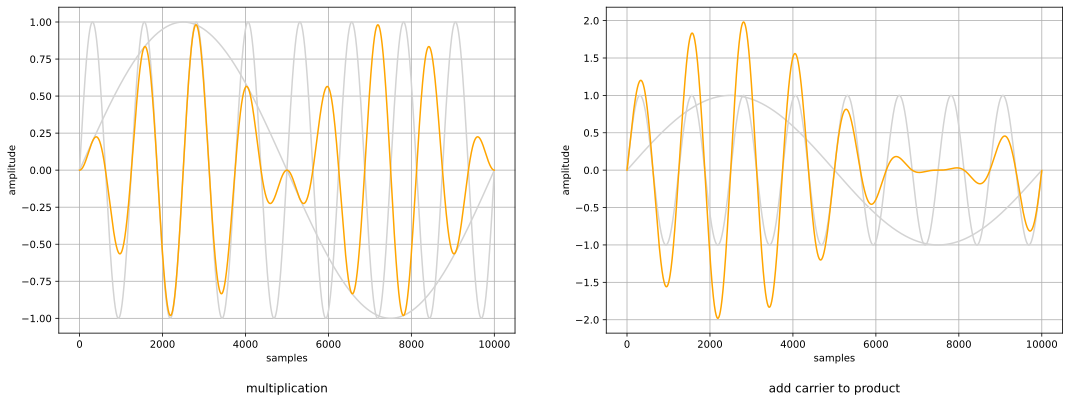

In [2]:
fs = 10000
f1 = 8
f2 = 1

x1 = np.arange(fs)
y1 = np.sin(2 * np.pi * x1 * f1 / fs)

x2 = np.arange(fs)
y2 = np.sin(2 * np.pi * x2 * f2 / fs)

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(18, 6))

#plot multiplication
ax0.plot(x1, y1, c='LightGrey')  # differential output
ax0.plot(x2, y2, c='LightGrey')  # differential output
ax0.plot(x2, y2 * y1, c='orange')  # differential output
ax0.grid()
ax0.set_xlabel('samples')
ax0.set_ylabel('amplitude')
ax0.set_title('multiplication', y=-0.2)

#plot multiplication with carrier added
ax1.plot(x1, y1, c='LightGrey')  # differential output
ax1.plot(x2, y2, c='LightGrey')  # differential output
ax1.plot(x2, y1 * y2 + y1, c='orange')  # differential output
ax1.grid()
ax1.set_xlabel('samples')
ax1.set_ylabel('amplitude')
ax1.set_title('add carrier to product', y=-0.2)
plt.show()


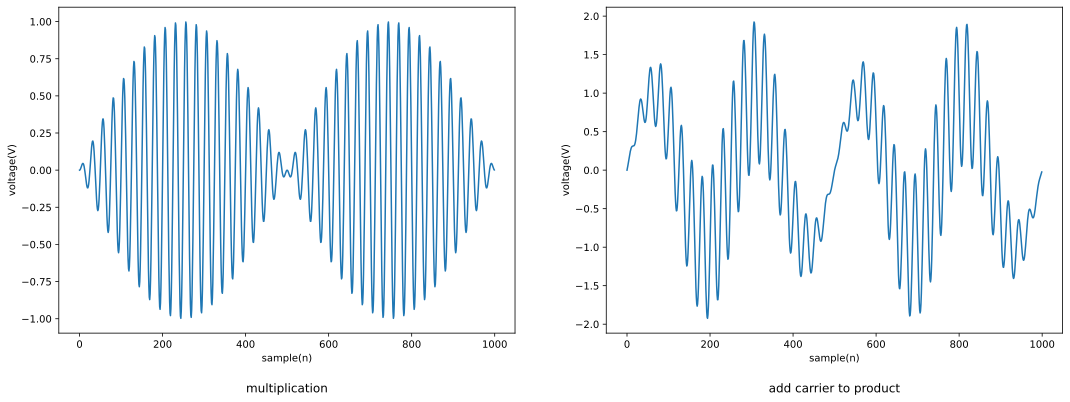

In [3]:
fs = 1000 # sample rate 
f = 8 # the frequency of the signal
f2 = 2
x = np.arange(fs) # the points on the x axis for plotting
# compute the value (amplitude) of the sin wave at the for each sample
y = np.sin(10 * np.pi * f * (x/fs)) * np.sin(np.pi * f2 * (x/fs))

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(18, 6))
ax0.plot(x, y)
ax0.set_xlabel('sample(n)')
ax0.set_ylabel('voltage(V)')
ax0.set_title('multiplication', y=-0.2)

y = (np.sin(10 * np.pi * f * (x/fs)) * np.sin(np.pi * f2 * (x/fs))) + np.sin(np.pi * f * (x/fs)) 
ax1.plot(x, y)
ax1.set_xlabel('sample(n)')
ax1.set_ylabel('voltage(V)')
ax1.set_title('add carrier to product', y=-0.2)


plt.show()

In [4]:
#load the diffpair schema
kicad_netlist_path = directory_path.joinpath('diffpair', 'diffpair.cir')
parser = SpiceParser(path=str(kicad_netlist_path))

In [5]:
#simulate diffpair with envelope
diffpair_envelope = parser.build_circuit(ground=5)
diffpair_envelope.include(spice_library['BC547B'])
diffpair_envelope.V('1', '+15V', diffpair_envelope.gnd, 'DC 15')
diffpair_envelope.V('2', '-15V', diffpair_envelope.gnd, 'DC -15')
diffpair_envelope.V('3', 'Vin_a', diffpair_envelope.gnd, 'DC 0V AC 0V SIN(0 25m 1k)')
diffpair_envelope.V('4', 'Vin_b', diffpair_envelope.gnd, 'DC 0V AC 0V PULSE(200m -4.5 1m 1u 15m 1u)')
simulator = diffpair_envelope.simulator(temperature=25, nominal_temperature=25)
analysis_envelope = simulator.transient(step_time=1@u_us, end_time=20@u_ms)

2021-01-19 17:57:28,483 - PySpice.Spice.Parser.Element - Parser.DEBUG - R 2 ['Net-_Q1-Pad3_', 'Net-_Q2-Pad3_'] ['33k'] {}
2021-01-19 17:57:28,484 - PySpice.Spice.Parser.Element - Parser.DEBUG - R 4 ['Vout_b', '+15V'] ['15k'] {}
2021-01-19 17:57:28,485 - PySpice.Spice.Parser.Element - Parser.DEBUG - R 1 ['Vout_a', '+15V'] ['15k'] {}
2021-01-19 17:57:28,486 - PySpice.Spice.Parser.Element - Parser.DEBUG - Q 3 ['Vout_b', 'GND', 'Net-_Q2-Pad3_'] [] {'model': 'BC547B'}
2021-01-19 17:57:28,488 - PySpice.Spice.Parser.Element - Parser.DEBUG - Q 2 ['Vout_a', 'Vin_a', 'Net-_Q2-Pad3_'] [] {'model': 'BC547B'}
2021-01-19 17:57:28,488 - PySpice.Spice.Parser.Element - Parser.DEBUG - R 3 ['-15V', 'Net-_Q1-Pad3_'] ['15k'] {}
2021-01-19 17:57:28,490 - PySpice.Spice.Parser.Element - Parser.DEBUG - Q 1 ['GND', 'Vin_b', 'Net-_Q1-Pad3_'] [] {'model': 'BC547B'}
2021-01-19 17:57:28,519 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.DEBUG - New instance for id 0
2021-01-19 17:57:28,520 - PySpice.Spice.Ng

In [6]:
#simulate  amplitude modulation
diffpair_am = parser.build_circuit(ground=5)
diffpair_am.include(spice_library['BC547B'])
diffpair_am.V('1', '+15V', diffpair_am.gnd, 'DC 15')
diffpair_am.V('2', '-15V', diffpair_am.gnd, 'DC -15')
diffpair_am.V('3', 'Vin_a', diffpair_am.gnd, 'DC 0V AC 0V SIN(0 25m 1k)')
diffpair_am.V('4', 'Vin_b', diffpair_am.gnd, 'DC 0V AC 0V SIN(0 5 100)')

simulator = diffpair_am.simulator(temperature=25, nominal_temperature=25)
analysis_am = simulator.transient(step_time=1@u_us, end_time=20@u_ms)

2021-01-19 17:57:28,923 - PySpice.Spice.Parser.Element - Parser.DEBUG - R 2 ['Net-_Q1-Pad3_', 'Net-_Q2-Pad3_'] ['33k'] {}
2021-01-19 17:57:28,924 - PySpice.Spice.Parser.Element - Parser.DEBUG - R 4 ['Vout_b', '+15V'] ['15k'] {}
2021-01-19 17:57:28,924 - PySpice.Spice.Parser.Element - Parser.DEBUG - R 1 ['Vout_a', '+15V'] ['15k'] {}
2021-01-19 17:57:28,926 - PySpice.Spice.Parser.Element - Parser.DEBUG - Q 3 ['Vout_b', 'GND', 'Net-_Q2-Pad3_'] [] {'model': 'BC547B'}
2021-01-19 17:57:28,926 - PySpice.Spice.Parser.Element - Parser.DEBUG - Q 2 ['Vout_a', 'Vin_a', 'Net-_Q2-Pad3_'] [] {'model': 'BC547B'}
2021-01-19 17:57:28,927 - PySpice.Spice.Parser.Element - Parser.DEBUG - R 3 ['-15V', 'Net-_Q1-Pad3_'] ['15k'] {}
2021-01-19 17:57:28,928 - PySpice.Spice.Parser.Element - Parser.DEBUG - Q 1 ['GND', 'Vin_b', 'Net-_Q1-Pad3_'] [] {'model': 'BC547B'}
2021-01-19 17:57:28,930 - PySpice.Spice.NgSpice.Simulation.NgSpiceSharedCircuitSimulator - Simulation.DEBUG - desk
.title KiCad schematic
.include C:\

2021-01-19 17:57:29,329 - PySpice.Probe.WaveForm.WaveForm - Unit.DEBUG - Conversion for <ufunc 'multiply'> is NEW_UNIT
2021-01-19 17:57:29,330 - PySpice.Probe.WaveForm.WaveForm - Unit.DEBUG - Conversion for <ufunc 'multiply'> is NEW_UNIT
2021-01-19 17:57:29,331 - PySpice.Probe.WaveForm.WaveForm - Unit.DEBUG - Conversion for <ufunc 'multiply'> is NEW_UNIT
2021-01-19 17:57:29,333 - PySpice.Probe.WaveForm.WaveForm - Unit.DEBUG - Conversion for <ufunc 'multiply'> is NEW_UNIT
2021-01-19 17:57:29,334 - PySpice.Probe.WaveForm.WaveForm - Unit.DEBUG - Conversion for <ufunc 'subtract'> is UNIT_MATCH
2021-01-19 17:57:29,338 - PySpice.Probe.WaveForm.WaveForm - Unit.DEBUG - Conversion for <ufunc 'multiply'> is NEW_UNIT
2021-01-19 17:57:29,339 - PySpice.Probe.WaveForm.WaveForm - Unit.DEBUG - Conversion for <ufunc 'subtract'> is UNIT_MATCH
2021-01-19 17:57:29,341 - PySpice.Probe.WaveForm.WaveForm - Unit.DEBUG - Conversion for <ufunc 'multiply'> is NEW_UNIT
2021-01-19 17:57:29,342 - PySpice.Probe.Wave

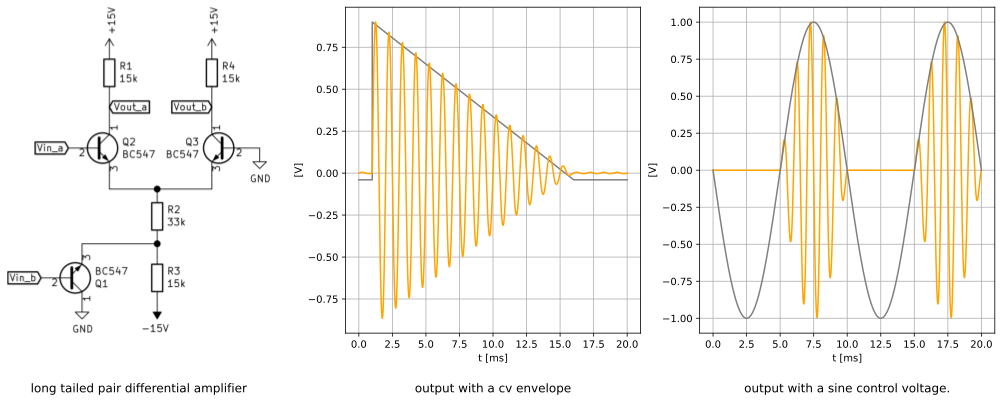

In [7]:
#plot the results
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=False, figsize=(18, 6))

#plot the image
img_diffpair_path = directory_path.joinpath('diffpair', 'diffpair.png')
img_diffpair = mpimg.imread(str(img_diffpair_path))
im = ax0.imshow(img_diffpair)
ax0.axis('off')
ax0.set_title('long tailed pair differential amplifier', y=-0.2)
        
#plot with envelope
ax1.plot(analysis_envelope['Vin_b'].abscissa*1000, analysis_envelope['Vin_b'] * 0.2 * -1, c='grey')  # envelope input (scaled)
ax1.plot(analysis_envelope['Vout_b'].abscissa*1000, analysis_envelope['Vout_b'] - analysis_envelope['Vout_a'], c='orange')  # differential output
ax1.grid()
ax1.set_xlabel('t [ms]')
ax1.set_ylabel('[V]')
ax1.set_title('output with a cv envelope', y=-0.2)

#plot the amplitude modulation
ax2.plot(analysis_am['Vout_b'].abscissa*1000, analysis_am['Vout_b'] - analysis_am['Vout_a'], c='orange')  # differential output
ax2.plot(analysis_am['Vout_b'].abscissa*1000, analysis_am['Vin_b'] * 0.2 * -1, c='grey')  # differential output
ax2.grid()
ax2.set_xlabel('t [ms]')
ax2.set_ylabel('[V]')
ax2.set_title('output with a sine control voltage.', y=-0.2)
plt.show()


more promising is it to use a four quadrant multiplier, also known as gilbert cell. the gilbert cell is designed around two differential amplifiers. the carrier signal switches between those. the result is a multiplication of the input voltages. the gilbert cell is mostly used for amplitude modulation in radio transmission. if you look at the integratd circuits like the 633 it can modulate signals up in the gigahertz range. the gilbert cell is not described in all details here, there is a good introduction from w2aew [[4][4]].




In [8]:
#load the gilbert_cell schema
kicad_netlist_path = directory_path.joinpath('gilbert_cell_2', 'gilbert_cell.cir')
parser = SpiceParser(path=str(kicad_netlist_path))

In [9]:
#simulate with envelope
gilbert_cell_envelope = parser.build_circuit(ground=5)
gilbert_cell_envelope.include(spice_library['BC547B'])
gilbert_cell_envelope.include(spice_library['TL072'])

gilbert_cell_envelope.V('1', '+15V', gilbert_cell_envelope.gnd, 'DC 15')
gilbert_cell_envelope.V('2', '-15V', gilbert_cell_envelope.gnd, 'DC -15')
gilbert_cell_envelope.V('3', 'AUDIO_IN', gilbert_cell_envelope.gnd, 'DC 0V AC 0V SIN(0 10m 1k)')
gilbert_cell_envelope.V('4', 'CV_IN', gilbert_cell_envelope.gnd, 'DC 0V AC 0V PULSE(0 20m 1m 0u 10m 1u)')
gilbert_cell_envelope.V('5', '+5V', gilbert_cell_envelope.gnd, 'DC 5')
gilbert_cell_envelope.V('6', '+2V', gilbert_cell_envelope.gnd, 'DC -7.5')
gilbert_cell_envelope.V('7', '+4V', gilbert_cell_envelope.gnd, 'DC 0')

simulator = gilbert_cell_envelope.simulator(temperature=25, nominal_temperature=25)
analysis_gilbert_cell_envelope = simulator.transient(step_time=1@u_us, end_time=20@u_ms)

2021-01-19 17:57:30,239 - PySpice.Spice.Parser.Element - Parser.DEBUG - Q 1 ['OUT_A', 'CV_IN', 'Net-_Q1-Pad3_'] [] {'model': 'BC547B'}
2021-01-19 17:57:30,240 - PySpice.Spice.Parser.Element - Parser.DEBUG - Q 3 ['OUT_B', 'GND', 'Net-_Q1-Pad3_'] [] {'model': 'BC547B'}
2021-01-19 17:57:30,240 - PySpice.Spice.Parser.Element - Parser.DEBUG - Q 4 ['OUT_A', 'GND', 'Net-_Q4-Pad3_'] [] {'model': 'BC547B'}
2021-01-19 17:57:30,241 - PySpice.Spice.Parser.Element - Parser.DEBUG - Q 6 ['OUT_B', 'CV_IN', 'Net-_Q4-Pad3_'] [] {'model': 'BC547B'}
2021-01-19 17:57:30,242 - PySpice.Spice.Parser.Element - Parser.DEBUG - Q 2 ['Net-_Q1-Pad3_', 'Net-_C1-Pad1_', 'Net-_Q2-Pad3_'] [] {'model': 'BC547B'}
2021-01-19 17:57:30,243 - PySpice.Spice.Parser.Element - Parser.DEBUG - Q 5 ['Net-_Q4-Pad3_', 'Net-_Q5-Pad2_', 'Net-_Q2-Pad3_'] [] {'model': 'BC547B'}
2021-01-19 17:57:30,244 - PySpice.Spice.Parser.Element - Parser.DEBUG - R 3 ['+15V', 'OUT_B'] ['720'] {}
2021-01-19 17:57:30,245 - PySpice.Spice.Parser.Element - 

In [10]:
#simulate ring modulation
gilbert_am = parser.build_circuit(ground=5)
gilbert_am.include(spice_library['BC547B'])
gilbert_am.include(spice_library['TL072'])

gilbert_am.V('1', '+15V', gilbert_am.gnd, 'DC 15')
gilbert_am.V('2', '-15V', gilbert_am.gnd, 'DC -15')
gilbert_am.V('3', 'AUDIO_IN', gilbert_am.gnd, 'DC 0V AC 0V SIN(0 10m 1k)')
gilbert_am.V('4', 'CV_IN', gilbert_am.gnd, 'DC 0V AC 0V SIN(20m 20m 100)')
gilbert_am.V('5', '+5V', gilbert_am.gnd, 'DC 5')
gilbert_am.V('6', '+2V', gilbert_am.gnd, 'DC -7.5')
gilbert_am.V('7', '+4V', gilbert_am.gnd, 'DC 0')

simulator = gilbert_am.simulator(temperature=25, nominal_temperature=25)
analysis_gilbert_cell_am = simulator.transient(step_time=1@u_us, end_time=20@u_ms)

2021-01-19 17:57:30,862 - PySpice.Spice.Parser.Element - Parser.DEBUG - Q 1 ['OUT_A', 'CV_IN', 'Net-_Q1-Pad3_'] [] {'model': 'BC547B'}
2021-01-19 17:57:30,864 - PySpice.Spice.Parser.Element - Parser.DEBUG - Q 3 ['OUT_B', 'GND', 'Net-_Q1-Pad3_'] [] {'model': 'BC547B'}
2021-01-19 17:57:30,865 - PySpice.Spice.Parser.Element - Parser.DEBUG - Q 4 ['OUT_A', 'GND', 'Net-_Q4-Pad3_'] [] {'model': 'BC547B'}
2021-01-19 17:57:30,867 - PySpice.Spice.Parser.Element - Parser.DEBUG - Q 6 ['OUT_B', 'CV_IN', 'Net-_Q4-Pad3_'] [] {'model': 'BC547B'}
2021-01-19 17:57:30,867 - PySpice.Spice.Parser.Element - Parser.DEBUG - Q 2 ['Net-_Q1-Pad3_', 'Net-_C1-Pad1_', 'Net-_Q2-Pad3_'] [] {'model': 'BC547B'}
2021-01-19 17:57:30,868 - PySpice.Spice.Parser.Element - Parser.DEBUG - Q 5 ['Net-_Q4-Pad3_', 'Net-_Q5-Pad2_', 'Net-_Q2-Pad3_'] [] {'model': 'BC547B'}
2021-01-19 17:57:30,869 - PySpice.Spice.Parser.Element - Parser.DEBUG - R 3 ['+15V', 'OUT_B'] ['720'] {}
2021-01-19 17:57:30,871 - PySpice.Spice.Parser.Element - 

In [11]:
#simulate ring modulation
gilbert_ring = parser.build_circuit(ground=5)
gilbert_ring.include(spice_library['BC547B'])
gilbert_ring.include(spice_library['TL072'])

gilbert_ring.V('1', '+15V', gilbert_ring.gnd, 'DC 15')
gilbert_ring.V('2', '-15V', gilbert_ring.gnd, 'DC -15')
gilbert_ring.V('3', 'AUDIO_IN', gilbert_ring.gnd, 'DC 0V AC 0V SIN(0 10m 1k)')
gilbert_ring.V('4', 'CV_IN', gilbert_ring.gnd, 'DC 0V AC 0V SIN(0 20m 100)')
gilbert_ring.V('5', '+5V', gilbert_ring.gnd, 'DC 5')
gilbert_ring.V('6', '+2V', gilbert_ring.gnd, 'DC -7.5')
gilbert_ring.V('7', '+4V', gilbert_ring.gnd, 'DC 0')

simulator = gilbert_ring.simulator(temperature=25, nominal_temperature=25)
analysis_gilbert_ring= simulator.transient(step_time=1@u_us, end_time=20@u_ms)

2021-01-19 17:57:31,479 - PySpice.Spice.Parser.Element - Parser.DEBUG - Q 1 ['OUT_A', 'CV_IN', 'Net-_Q1-Pad3_'] [] {'model': 'BC547B'}
2021-01-19 17:57:31,480 - PySpice.Spice.Parser.Element - Parser.DEBUG - Q 3 ['OUT_B', 'GND', 'Net-_Q1-Pad3_'] [] {'model': 'BC547B'}
2021-01-19 17:57:31,481 - PySpice.Spice.Parser.Element - Parser.DEBUG - Q 4 ['OUT_A', 'GND', 'Net-_Q4-Pad3_'] [] {'model': 'BC547B'}
2021-01-19 17:57:31,482 - PySpice.Spice.Parser.Element - Parser.DEBUG - Q 6 ['OUT_B', 'CV_IN', 'Net-_Q4-Pad3_'] [] {'model': 'BC547B'}
2021-01-19 17:57:31,483 - PySpice.Spice.Parser.Element - Parser.DEBUG - Q 2 ['Net-_Q1-Pad3_', 'Net-_C1-Pad1_', 'Net-_Q2-Pad3_'] [] {'model': 'BC547B'}
2021-01-19 17:57:31,484 - PySpice.Spice.Parser.Element - Parser.DEBUG - Q 5 ['Net-_Q4-Pad3_', 'Net-_Q5-Pad2_', 'Net-_Q2-Pad3_'] [] {'model': 'BC547B'}
2021-01-19 17:57:31,485 - PySpice.Spice.Parser.Element - Parser.DEBUG - R 3 ['+15V', 'OUT_B'] ['720'] {}
2021-01-19 17:57:31,486 - PySpice.Spice.Parser.Element - 

2021-01-19 17:57:32,407 - PySpice.Probe.WaveForm.WaveForm - Unit.DEBUG - Conversion for <ufunc 'multiply'> is NEW_UNIT
2021-01-19 17:57:32,409 - PySpice.Probe.WaveForm.WaveForm - Unit.DEBUG - Conversion for <ufunc 'multiply'> is NEW_UNIT
2021-01-19 17:57:32,412 - PySpice.Probe.WaveForm.WaveForm - Unit.DEBUG - Conversion for <ufunc 'multiply'> is NEW_UNIT
2021-01-19 17:57:32,417 - PySpice.Probe.WaveForm.WaveForm - Unit.DEBUG - Conversion for <ufunc 'multiply'> is NEW_UNIT
2021-01-19 17:57:32,418 - PySpice.Probe.WaveForm.WaveForm - Unit.DEBUG - Conversion for <ufunc 'multiply'> is NEW_UNIT
2021-01-19 17:57:32,426 - PySpice.Probe.WaveForm.WaveForm - Unit.DEBUG - Conversion for <ufunc 'multiply'> is NEW_UNIT
2021-01-19 17:57:32,431 - PySpice.Probe.WaveForm.WaveForm - Unit.DEBUG - Conversion for <ufunc 'multiply'> is NEW_UNIT
2021-01-19 17:57:32,432 - PySpice.Probe.WaveForm.WaveForm - Unit.DEBUG - Conversion for <ufunc 'multiply'> is NEW_UNIT
2021-01-19 17:57:32,435 - PySpice.Probe.WaveForm

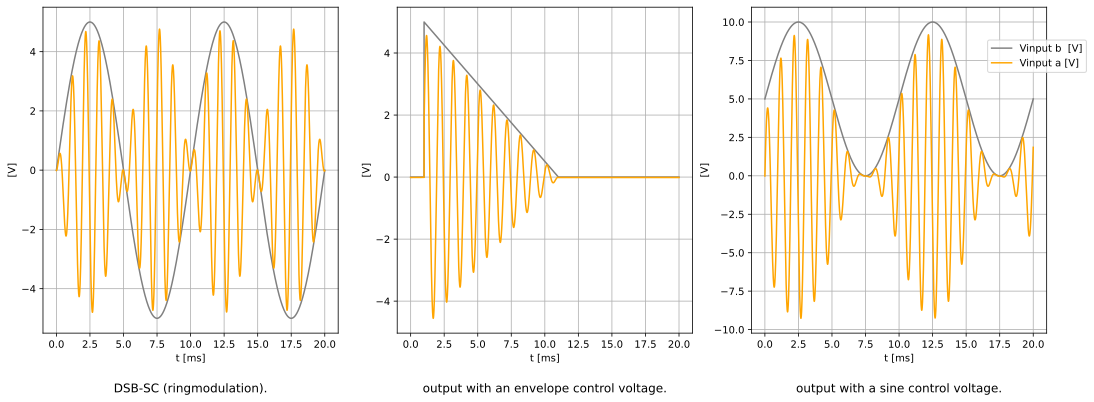

In [12]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=False, figsize=(18, 6))

#plot the image
#img_diffpair_path = directory_path.joinpath('gilbert_cell', 'g2074.png')
#img_gilbert = mpimg.imread(str(img_diffpair_path))
#im = ax0.imshow(img_gilbert)
#ax0.axis('off')
#ax0.set_title('gilbert cell.', y=-0.2)

#plot the ringmodulation
ax0.plot(analysis_gilbert_ring['CV_IN'].abscissa*1000, analysis_gilbert_ring['CV_IN']*250, c='grey')  # modulating
ax0.plot(analysis_gilbert_ring['OUT'].abscissa*1000, analysis_gilbert_ring['OUT'], c='orange')  # differential output

ax0.grid()
ax0.set_xlabel('t [ms]')
ax0.set_ylabel('[V]')
ax0.set_title('DSB-SC (ringmodulation).', y=-0.2)

#plot the envelope
ax1.plot(analysis_gilbert_cell_envelope['CV_IN'].abscissa*1000, analysis_gilbert_cell_envelope['CV_IN']*250, c='grey')  # modulating
ax1.plot(analysis_gilbert_cell_envelope['OUT'].abscissa*1000, analysis_gilbert_cell_envelope['OUT'], c='orange')  # differential output

ax1.grid()
ax1.set_xlabel('t [ms]')
ax1.set_ylabel('[V]')
ax1.set_title('output with an envelope control voltage.', y=-0.2)

#plot the ring modulation
ax2.plot(analysis_gilbert_cell_am['CV_IN'].abscissa*1000, analysis_gilbert_cell_am['CV_IN']*250, c='grey')  # modulating
ax2.plot(analysis_gilbert_cell_am['OUT'].abscissa*1000, analysis_gilbert_cell_am['OUT'], c='orange')  # differential 
ax2.legend(('Vinput b  [V]', 'Vinput a [V]', 'Vout [V]'), loc=(.8, .8))
ax2.grid()
ax2.set_xlabel('t [ms]')
ax2.set_ylabel('[V]')
ax2.set_title('output with a sine control voltage.', y=-0.2)

plt.show()


this is not real amplitude modulation. when the signal is negative the phase of the output is inverted. this can be adjusted by the bias voltage of the control voltage. the control voltage has to be positive at all time. 


## *construction*

for the final circuit input and output buffering and biasing is needed. the buffering is done with opamps. 

![schematic of the pegel vca](/images/pegel_schematic.svg)


first we design the input stage. the input voltage for the X signal should be 10mV and 20mV for the control voltage.


In [13]:
#load the kicad schema
directory_path = Path(os.path.abspath('')).resolve()
kicad_netlist_path = directory_path.joinpath('main', 'main.cir')
parser = SpiceParser(path=str(kicad_netlist_path))


In [14]:
#ringmodulation
ringmod_schema = parser.build_circuit(ground=5)
ringmod_schema.include(spice_library['TL072c'])
ringmod_schema.include(spice_library['AD633'])

ringmod_schema.V('1', '+15V', ringmod_schema.gnd, 'DC 15')
ringmod_schema.V('2', '-15V', ringmod_schema.gnd, 'DC -15')
ringmod_schema.V('3', 'IN_Xa', ringmod_schema.gnd, 'DC 5V AC 5V SIN(0V 5V 1k)')
ringmod_schema.V('4', 'IN_Ya', ringmod_schema.gnd, 'DC 5V AC 5V SIN(0V 5V 100)')
ringmod_schema.V('5', 'IN_Za', ringmod_schema.gnd, 'DC 0V AC 0V')

simulator = ringmod_schema.simulator(temperature=25, nominal_temperature=25)
analysis_ringmod = simulator.transient(step_time=10@u_us, end_time=20@u_ms)

Shared.DEBUG - b'stdout -15v                                       -15'
2021-01-19 17:57:33,471 - PySpice.Spice.NgSpice.Shared - Shared.DEBUG - b'stdout +15v                                        15'
2021-01-19 17:57:33,472 - PySpice.Spice.NgSpice.Shared - Shared.DEBUG - b'stdout xu1.xu1a.99                                  0'
2021-01-19 17:57:33,473 - PySpice.Spice.NgSpice.Shared - Shared.DEBUG - b'stdout xu1.xu1a.10                          -0.398582'
2021-01-19 17:57:33,473 - PySpice.Spice.NgSpice.Shared - Shared.DEBUG - b'stdout in_xa                                        0'
2021-01-19 17:57:33,474 - PySpice.Spice.NgSpice.Shared - Shared.DEBUG - b'stdout xu1.xu1a.9                                   0'
2021-01-19 17:57:33,476 - PySpice.Spice.NgSpice.Shared - Shared.DEBUG - b'stdout xu1.xu1a.8                         0.000131052'
2021-01-19 17:57:33,477 - PySpice.Spice.NgSpice.Shared - Shared.DEBUG - b'stdout xu1.xu1b.11                           -14.6546'
2021-01-19 17:57:33,478 -

In [15]:
#amplitude modulation
am_schema = parser.build_circuit(ground=5)
am_schema.include(spice_library['TL072c'])
am_schema.include(spice_library['AD633'])

am_schema.V('1', '+15V', am_schema.gnd, 'DC 15')
am_schema.V('2', '-15V', am_schema.gnd, 'DC -15')
am_schema.V('3', 'IN_Xa', am_schema.gnd, 'DC 10V AC 5V SIN(0V 5V 1k)')
am_schema.V('4', 'IN_Ya', am_schema.gnd, 'DC 5V AC 5V SIN(0V 5V 100)')
am_schema.V('5', 'IN_Za', am_schema.gnd, 'DC 5V AC 5V SIN(0V 2.5V 1k)')

simulator = am_schema.simulator(temperature=25, nominal_temperature=25)
analysis_am = simulator.transient(step_time=10@u_us, end_time=20@u_ms)

Shared.DEBUG - b'stdout -15v                                       -15'
2021-01-19 17:57:34,575 - PySpice.Spice.NgSpice.Shared - Shared.DEBUG - b'stdout +15v                                        15'
2021-01-19 17:57:34,576 - PySpice.Spice.NgSpice.Shared - Shared.DEBUG - b'stdout xu1.xu1a.99                                  0'
2021-01-19 17:57:34,577 - PySpice.Spice.NgSpice.Shared - Shared.DEBUG - b'stdout xu1.xu1a.10                          -0.398582'
2021-01-19 17:57:34,578 - PySpice.Spice.NgSpice.Shared - Shared.DEBUG - b'stdout in_xa                                        0'
2021-01-19 17:57:34,579 - PySpice.Spice.NgSpice.Shared - Shared.DEBUG - b'stdout xu1.xu1a.9                                   0'
2021-01-19 17:57:34,580 - PySpice.Spice.NgSpice.Shared - Shared.DEBUG - b'stdout xu1.xu1a.8                         0.000131052'
2021-01-19 17:57:34,581 - PySpice.Spice.NgSpice.Shared - Shared.DEBUG - b'stdout xu1.xu1b.11                           -14.6546'
2021-01-19 17:57:34,582 -

In [16]:
#vca
vca_schema = parser.build_circuit(ground=5)
vca_schema.include(spice_library['TL072c'])
vca_schema.include(spice_library['AD633'])

vca_schema.V('1', '+15V', vca_schema.gnd, 'DC 15')
vca_schema.V('2', '-15V', vca_schema.gnd, 'DC -15')
vca_schema.V('3', 'IN_Xa', vca_schema.gnd, 'DC 10V AC 5V SIN(0V 5V 1k)')
vca_schema.V('4', 'IN_Ya', vca_schema.gnd, 'DC 5V AC 5V PULSE(0V 10V 1m 1m 15m 1m)')
vca_schema.V('5', 'IN_Za', vca_schema.gnd, 'DC 0V AC 0V')

simulator = vca_schema.simulator(temperature=25, nominal_temperature=25)
analysis_vca = simulator.transient(step_time=10@u_us, end_time=20@u_ms)

Shared.DEBUG - b'stdout -15v                                       -15'
2021-01-19 17:57:35,592 - PySpice.Spice.NgSpice.Shared - Shared.DEBUG - b'stdout +15v                                        15'
2021-01-19 17:57:35,593 - PySpice.Spice.NgSpice.Shared - Shared.DEBUG - b'stdout xu1.xu1a.99                                  0'
2021-01-19 17:57:35,594 - PySpice.Spice.NgSpice.Shared - Shared.DEBUG - b'stdout xu1.xu1a.10                          -0.398582'
2021-01-19 17:57:35,595 - PySpice.Spice.NgSpice.Shared - Shared.DEBUG - b'stdout in_xa                                        0'
2021-01-19 17:57:35,596 - PySpice.Spice.NgSpice.Shared - Shared.DEBUG - b'stdout xu1.xu1a.9                                   0'
2021-01-19 17:57:35,597 - PySpice.Spice.NgSpice.Shared - Shared.DEBUG - b'stdout xu1.xu1a.8                         0.000131052'
2021-01-19 17:57:35,598 - PySpice.Spice.NgSpice.Shared - Shared.DEBUG - b'stdout xu1.xu1b.11                           -14.6546'
2021-01-19 17:57:35,599 -

2021-01-19 17:57:36,496 - PySpice.Probe.WaveForm.WaveForm - Unit.DEBUG - Conversion for <ufunc 'multiply'> is NEW_UNIT
2021-01-19 17:57:36,499 - PySpice.Probe.WaveForm.WaveForm - Unit.DEBUG - Conversion for <ufunc 'multiply'> is NEW_UNIT
2021-01-19 17:57:36,502 - PySpice.Probe.WaveForm.WaveForm - Unit.DEBUG - Conversion for <ufunc 'multiply'> is NEW_UNIT
2021-01-19 17:57:36,505 - PySpice.Probe.WaveForm.WaveForm - Unit.DEBUG - Conversion for <ufunc 'multiply'> is NEW_UNIT
2021-01-19 17:57:36,508 - PySpice.Probe.WaveForm.WaveForm - Unit.DEBUG - Conversion for <ufunc 'multiply'> is NEW_UNIT
2021-01-19 17:57:36,510 - PySpice.Probe.WaveForm.WaveForm - Unit.DEBUG - Conversion for <ufunc 'multiply'> is NEW_UNIT


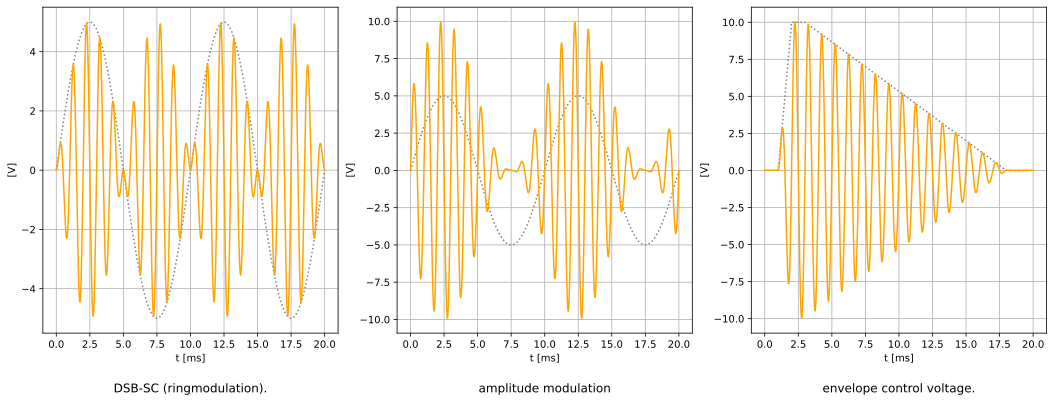

In [17]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=False, figsize=(18, 6))

#plot the ringmodulation
ax0.plot(analysis_ringmod['IN_Ya'].abscissa*1000, analysis_ringmod['IN_Ya'], c='grey', linestyle=':')
ax0.plot(analysis_ringmod['OUT_a'].abscissa*1000, analysis_ringmod['OUT_a'], c='orange') 
ax0.grid()
ax0.set_xlabel('t [ms]')
ax0.set_ylabel('[V]')
ax0.set_title('DSB-SC (ringmodulation).', y=-0.2)

#plot the amplitude modulation
ax1.plot(analysis_am['IN_Ya'].abscissa*1000, analysis_am['IN_Ya'], c='grey', linestyle=':') 
ax1.plot(analysis_am['OUT_a'].abscissa*1000, analysis_am['OUT_a'], c='orange') 
ax1.grid()
ax1.set_xlabel('t [ms]')
ax1.set_ylabel('[V]')
ax1.set_title('amplitude modulation', y=-0.2)

#plot the envelope
ax2.plot(analysis_vca['IN_Ya'].abscissa*1000, analysis_vca['IN_Ya'], c='grey', linestyle=':')
ax2.plot(analysis_vca['OUT_a'].abscissa*1000, analysis_vca['OUT_a'], c='orange') 
ax2.grid()
ax2.set_xlabel('t [ms]')
ax2.set_ylabel('[V]')
n = ax2.set_title('envelope control voltage.', y=-0.2)


In [18]:
import unittest

class TestInputVoltages(unittest.TestCase):
    
    def test_ringmod(self):
        self.assertAlmostEqual(4.95, np.max(np.array(analysis_ringmod.OUT_a)), places=1, msg='ringmod input max voltage x')
        self.assertAlmostEqual(0, np.average(np.array(analysis_ringmod.OUT_a)), places=1, msg='ringmod input average voltage x')

    def test_am(self):
        self.assertAlmostEqual(9.95, np.max(np.array(analysis_am.OUT_a)), places=1, msg='am input max voltage x')
        self.assertAlmostEqual(0, np.average(np.array(analysis_am.OUT_a)), places=1, msg='am input average voltage x')

    def test_vca(self):
        self.assertAlmostEqual(10, np.max(np.array(analysis_vca.OUT_a)), places=1, msg='vca input voltage x')
        self.assertAlmostEqual(0.01, np.average(np.array(analysis_vca.OUT_a)), places=1, msg='vca input voltage y')



In [19]:
unittest.main(argv=[''], verbosity=0, exit=False)

----------------------------------------------------------------------
Ran 3 tests in 0.002s

OK


## *references*

- [VCA Techniques Investigated][1] Rod Elliott (ESP)
- [Popular Electronics][2] Keyiing and VCA citcuits for electronic music instruments 
- [VCA-1][3] Thomas Henry CA3080 vca
- [VCA-3][4] René Schmitz differential pair vca
- [#223][5]: Basics of the Gilbert Cell | Analog Multiplier | Mixer | Modulator
- [#224][6]: AM & DSB-SC Modulation with the Gilbert Cell
- [Analog Devices][8]: Analog multiplier application guide 
- [AD633][9]: Datasheet 


[1]: https://sound-au.com/articles/vca-techniques.html
[2]: https://tinaja.com/glib/pop_elec/mus_keying_vca_1+2_75.pdf
[3]: https://www.birthofasynth.com/Thomas_Henry/Pages/VCA-1.html
[4]: https://www.schmitzbits.de/vca3.png
[5]: https://www.youtube.com/watch?v=7nmmb0pqTU0&t=2s
[6]: https://www.youtube.com/watch?v=38OQub2Vi2Q
[7]: http://www.ecircuitcenter.com/Circuits/BJT_Diffamp1/BJT_Diffamp1.htm
[8]: https://www.analog.com/media/en/training-seminars/design-handbooks/ADI_Multiplier_Applications_Guide.pdf
[9]: https://www.analog.com/media/en/technical-documentation/data-sheets/AD633.pdf



